In [1]:
import pyclesperanto_prototype as cle
from skimage.io import imread
import numpy as np
from typing import Callable
from functools import wraps
from toolz import curry
import dask.array as da
import inspect
import napari
import magicgui
from time import sleep
from napari_time_slicer import time_slicer

In [2]:
# decorator that converts the output to a numpy array
@curry
def output_to_numpy(function: Callable) -> Callable:
    @wraps(function)
    def worker_function(*args, **kwargs):
        # call the decorated function
        result = function(*args, **kwargs)
        return np.asarray(result)
    
    return worker_function

@curry
def plugin_function(
        function: Callable,
        argument_to_be_tiled: str,
        overlap_width: int = 0
) -> Callable:
    # copied from https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/pyclesperanto_prototype/_tier0/_plugin_function.py
    @wraps(function)
    def worker_function(*args, **kwargs):

        sig = inspect.signature(function)
        # create mapping from position and keyword arguments to parameters
        # will raise a TypeError if the provided arguments do not match the signature
        # https://docs.python.org/3/library/inspect.html#inspect.Signature.bind
        bound = sig.bind(*args, **kwargs)
        # set default values for missing arguments
        # https://docs.python.org/3/library/inspect.html#inspect.BoundArguments.apply_defaults
        bound.apply_defaults()

        

        # copy images to SimpleITK-types, and create output array if necessary
        value = bound.arguments[argument_to_be_tiled]
        if 'dask.array.core.Array' in str(type(value)):
            #apply bound function to dask array
            wrapped_function = output_to_numpy(function)
            import dask.array as da
            return da.map_overlap(wrapped_function, value, depth=overlap_width, boundary=0)

        # call the decorated function
        return function(*bound.args, **bound.kwargs)


    # worker_function.__module__ = "napari_simpleitk_image_processing"

    return worker_function


In [3]:
#@plugin_function(argument_to_be_tiled="image")
@time_slicer
def gaussian_blur(image: "napari.types.ImageData", sigma: float = 1) -> "napari.types.ImageData":
    print(f"blurring image with shape {image.shape}")
    # sleep(0.1)
    return cle.gaussian_blur(image, sigma_z=sigma, sigma_x=sigma, sigma_y=sigma)

In [4]:
#@plugin_function(argument_to_be_tiled="image")
@time_slicer
def threshold_otsu(image: "napari.types.ImageData") -> "napari.types.LabelsData":
    print("thresholding image with shape {image.shape}")
    # sleep(0.1)
    return cle.threshold_otsu(image)

In [5]:
#@plugin_function(argument_to_be_tiled="labels")
@time_slicer
def connected_components_labeling_box(labels: "napari.types.LabelsData") -> "napari.types.LabelsData":
    print("connected components labeling image with shape {labels.shape}")
    # sleep(0.1)
    return cle.connected_components_labeling_box(labels)

In [6]:
image = imread('data/timelapse.tif')
image.shape

(100, 1, 235, 389)

In [7]:
dask_image = da.from_array(image, chunks=(80, 80))
blurred = gaussian_blur(dask_image, sigma=1)

ValueError: Chunks and shape must be of the same length/dimension. Got chunks=(80, 80), shape=(100, 1, 235, 389)

In [ ]:
.from_array(image, chunks=(80, 80))
blurred = gaussian_blur(dask_image, sigma=1)

In [ ]:
result = connected_components_labeling_box(threshold_otsu(gaussian_blur(dask_image, sigma=1)))

blurring image with shape (340, 340)
thresholding image with shape {image.shape}
connected components labeling image with shape {labels.shape}


cl.OCLArray([[3.5692945, 3.4304605, 3.3102393, ..., 2.6257823, 2.719311 ,
        2.747696 ],
       [4.5238986, 4.1445546, 3.777236 , ..., 2.6395361, 2.6214247,
        2.4673004],
       [5.61024  , 4.9632955, 4.297552 , ..., 2.5773327, 2.4855475,
        2.2585127],
       ...,
       [1.6901623, 1.5458376, 1.4027843, ..., 1.1710273, 1.159317 ,
        1.0721133],
       [1.6257225, 1.5855047, 1.4278793, ..., 1.2449932, 1.1343305,
        1.0359428],
       [1.7723126, 1.6674958, 1.416185 , ..., 1.2668574, 1.0980834,
        1.0172366]], dtype=float32)
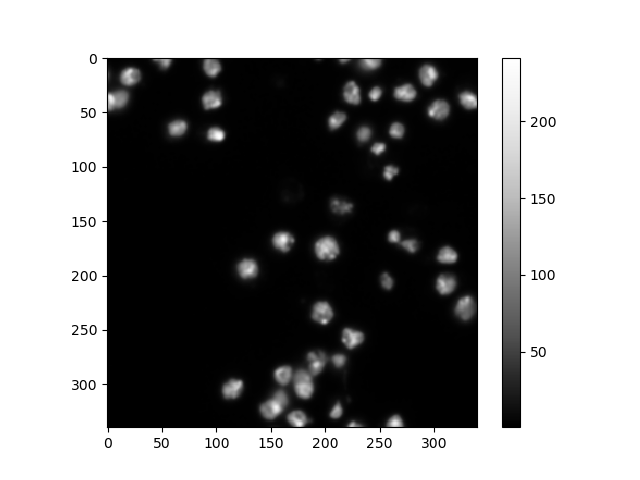
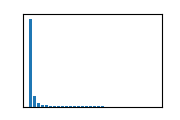

In [ ]:
blurred

In [ ]:
computed = blurred.compute()
computed

AttributeError: 'OCLArray' object has no attribute 'compute'

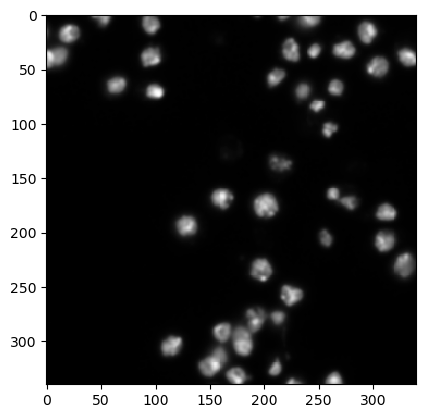

In [ ]:
cle.imshow(computed)

In [ ]:
thresholded = threshold_otsu(blurred)
thresholded

thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}


dask.array<threshold_otsu, shape=(340, 340), dtype=uint8, chunksize=(80, 80), chunktype=numpy.ndarray>

blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 20)
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 20)
thresholding image with shape {image.shape}thresholding image with shape {image.shape}

thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 20)
blurring image with shape (80, 80)


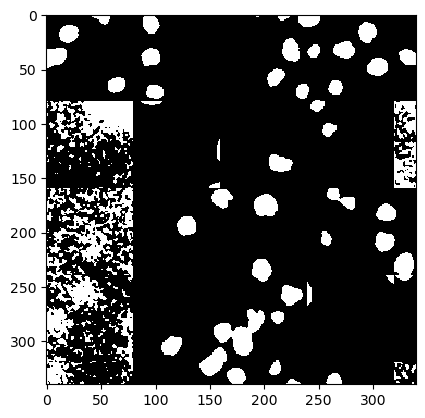

In [ ]:
cle.imshow(thresholded)

In [8]:
viewer = napari.Viewer()

In [9]:
viewer.add_image(image)

<Image layer 'image' at 0x287c197c0>

In [ ]:
viewer.window.add_dock_widget(magicgui.magicgui(threshold_otsu), area='right')

In [ ]:
viewer.add_labels(result)

blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 20)
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 80)
blurring image with shape (80, 20)
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
thresholding image with shape {image.shape}
connected components labeling image with shape {labels.shape}
connected components labeling image with shape {labels.shape}
connected components labeling image with shape {labels.shape}
connected components lab

<Labels layer 'result' at 0x28fe62130>

In [10]:
viewer.window.add_dock_widget(magicgui.magicgui(connected_components_labeling_box), area='right')
viewer.window.add_dock_widget(magicgui.magicgui(gaussian_blur), area='right')
viewer.window.add_dock_widget(magicgui.magicgui(threshold_otsu), area='right')

blurring image with shape (235, 389)
thresholding image with shape {image.shape}
connected components labeling image with shape {labels.shape}
